In [1]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019_research_right.csv')
politics = pd.read_csv('9th_legislator_promise.csv')
fb.page_name.unique() #觀察人名在資料集中叫什麼名字
politics.姓名.unique()

array(['吳思瑤', '姚文智', '何志偉', '蔣萬安', '李彥秀', '林昶佐', '蔣乃辛', '費鴻泰', '賴士葆',
       '呂 孫 綾', '林 淑 芬', '高志鵬', '余天', '吳 秉 叡', '蘇 巧 慧', '張 宏 陸', '羅 致 政',
       '江 永 昌', '林 德 福', '吳 琪 銘', '羅 明 才', '黃 國 昌', '蔡適應', '鄭 運 鵬',
       '陳賴素美', '陳學聖', '鄭寶清', '呂玉玲', '趙正宇', '林為洲', '柯建銘', '陳超明', '徐志榮',
       '蔡其昌', '顏寬恒', '洪慈庸', '張廖萬堅', '盧秀燕', '沈智慧', '黃國書', '何欣純', '江啟臣',
       '王惠美', '柯呈枋', '黃秀芳', '洪宗熠', '陳素月', '馬 文 君', '許 淑 華', '蘇 治 芬',
       '劉 建 國', '李 俊 俋', '蔡 易 餘', '陳 明 文', '葉宜津', '黃偉哲', '郭國文  ', '陳亭妃',
       '林俊憲', '王定宇', '邱 議 瑩', '邱 志 偉', '劉 世 芳', '林 岱 樺', '管 碧 玲', '李 昆 澤',
       '趙 天 麟', '馬 凱 妮', '賴 瑞 隆', '蘇震清', '鍾佳濱', '莊瑞雄', '陳歐珀', '蕭美琴',
       '劉櫂豪', '楊 曜', '楊鎮浯', '陳玉珍', '陳雪生', '廖國棟', '鄭天財', '陳瑩', '高金素梅',
       '簡東明', '孔文吉', nan], dtype=object)

In [2]:
lo = fb[fb.page_name == "羅致政粉絲團"]
lo.head(1)

,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,link_name,link_description,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count
23477,182836328407031_2219870311370279,182836328407031,羅致政粉絲團,政治人物,違法兼職，事證明確，卡不卡管，台大自斷,NaN,link,https://www.facebook.com/182836328407031/posts/2219870311370279/,2019-01-15T06:40:53+0000,2019-01-15T14:40:53,...,管中閔違法兼職 監察院7：4通過彈劾 | 蘋果日報,台大校長管中閔已在上周上任，不過，對於他過去擔任學校主管及政府部門任職時在外兼職違法事宜，監察院今天召開管中閔兼職的彈劾審查，結果以7：4通...,1029,0,0,0,0,0,42,29


In [3]:
lo['new_date'] = pd.to_datetime(lo['created_time_taipei']).dt.date
lo['month_year'] = pd.to_datetime(lo['new_date']).dt.to_period('M')
lo.head(1)

<ipython-input-3-067a578daaf3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lo['new_date'] = pd.to_datetime(lo['created_time_taipei']).dt.date
<ipython-input-3-067a578daaf3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lo['month_year'] = pd.to_datetime(lo['new_date']).dt.to_period('M')


,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,month_year
23477,182836328407031_2219870311370279,182836328407031,羅致政粉絲團,政治人物,違法兼職，事證明確，卡不卡管，台大自斷,NaN,link,https://www.facebook.com/182836328407031/posts/2219870311370279/,2019-01-15T06:40:53+0000,2019-01-15T14:40:53,...,1029,0,0,0,0,0,42,29,2019-01-15,2019-01


In [4]:
# 依照按讚數 低到高排序
lo = lo.sort_values(by=['like_count'])
# 用新的排序當作順序
lo.reset_index(inplace=True)

結巴斷詞 jieba

len(lo): 看羅致政的貼文總共有幾筆
list(lo['message']): 把要斷詞的內容轉成 list 格式
創造一個新的dataframe叫做lo_docs，型態是pandas.core.frame.DataFrame
原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [5]:
doc_names = range(len(lo)) #有幾篇文章 : 444 篇文章
doc_names

range(0, 871)

In [6]:
lo = lo.replace(np.nan, '', regex=True) # 將nan取代成空白字串
text_list = list(lo['message']) # 把所有message轉成一個list 用for iterate

In [7]:
# 先看第一個
words = jieba.lcut(text_list[0], cut_all = False) # lcut return a "list"
print(words)

[]


In [8]:
words = jieba.cut(text_list[0], cut_all = False) 
print(words)
#for word in words:
 #   print(word)

<generator object Tokenizer.cut at 0x7fd5c9ef39e0>


In [9]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")

punctuation = "、，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
lo_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
lo_docs['jieba_results'] = lo_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text)
    text = re.sub(r'[0-9]','',text)
    text = re.sub(r'[a-zA-Z]','',text)
    s = pd.Series({'jieba_results': text})
    lo_docs = lo_docs.append(s, ignore_index=True)
    #每次的斷詞結果都加回liu_docs

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/bb/vrfcp_x10vb62mbgn3fyfn640000gp/T/jieba.cache
Loading model cost 0.691 seconds.
Prefix dict has been built succesfully.


In [10]:
#lo_docs.iloc[400:,]  #從讚數最多的檢查

In [11]:
lo_docs

,jieba_results
0,
1,每年 端午 節 都 會 被 問到 北部 粽 和 南部 粽 你 喜歡 吃 哪個 最近 連冰 粽和住 海邊 的 粽 愛惜 生命 大家 知道 就 好 也 參戰 \r\r# 我小時候 最常 吃鹼 粽 沾 砂糖 \r\r你們 最想 吃 哪個 請 留言 告訴 我 ！
2,⚠ 提醒您 ️ / 前記 得 要 報稅 ⚠ ️ \r今年 政府 不 只 減稅 政策 讓 全民 超 有感 還開放 線上 申報 報稅 不用 再 排隊 了 👍 \r趕緊 分享 給親 朋 好友 吧 \r立即 線上 申報 / / . / \r\r# 報稅 最 後 天 \r# 減稅 超 有感 \r\r左圖 是 插 畫家 畫的 太有 創意 了 ！
3,韓國瑜 舉杯 翹 小指 專家 讚 聰明 又 省力 \r羅致政 關燈 縮 拇指 小編 讚 聰明 又 省電 \r\r# 世界 地球日 \r# 關燈 救 地球
4,今日 大雨 ☔ ️ 提醒 民眾 留意 ❗ ️ \r注意 雷擊 及 強陣風 低窪 以及 易 淹水 地區 也 請 慎防 積水 山區 請 提防 坍方 及 落石 。 \r\r☎ ️ 若有 受困 人員 危害 請 直接 撥 打 # \r☎ ️ 新北市 無人員 危害 災情 通報 請 打 # \r☎ ️ 暴雨 致 交通管制 事故 請 打 # \r☎ ️ 災情 資訊 詢問 請 打 # - 轉 \r\r若 有 個 別 需要 也 可 撥 打 羅致政 服務 處 專線 \r - -
...,...
866,真情 相挺 \r\r謝謝 我 的 好友 丁學偉 在 他 兒子 生日 當天 特別 趕來 站台 幽默 又 中肯 的 助講演說 。 \r\r學偉兄 非藍非綠 在 地板 橋人 ！
867,這是 范世平 教授 人生 第一次 站台 & 助講 的 初 體驗 選擇 到 板橋 推薦 致政 非常 難得 \r\r他 非常 不屑 吳斯懷 身為 月領 十多 萬 的 退役 中將 卻 敵 我 不分 國民黨 還把吳 列入 不分區 立委 第四名 準 立委 名單 。 世 平台 上期 許 致政 當吳斯懷 的 剋星 把 他 擋 在 國防 外交 委員 會門外 \r\r從 影片 中范 教授 說 的 台語 大家 應該 聽 得出 來 他 是 外省 第二代 但 對 於 大是大非 的 台灣 價值 無關 省籍 。 謝謝 世平 你 的 首次 站台 我 的 由衷 感激 ！
868,前天 晚上 在 後埔 的 造勢 晚會 上 按 原來 的 節目 流程 安排 亮吟 上台 唱歌 但 她 唱 完 後 我 的 好友 基清 主持人 臨場 脫稿 把 亮吟 留在 台上 他 說 現在 已經 是 選戰 的 最 關鍵 的 時刻 了 日後聽 妳 唱歌 的 機會 很多 妳 要 不要 幫 致政 說 幾句 話 為 他 加油 催票 \r\r習慣 聽亮 吟唱 歌為 我助選 卻 是 第一次 聽 她 為 我 站台 助講 在 事先 完全 沒準備 之下 她 率真 質樸 的 口吻 真情流露 感動 了 我 也 感動 了 現場 近 千位 鄉親 支持者 \r\r謝謝 亮吟 和 大家 分享 她 的 這段 話 ～
869,資深 媒體 人 康仁俊 年 他 曾 代表 親民黨 在 板橋 選 立委 板橋 對 他 來 說 毫不 陌生 。 \r\r這次 他 跨黨 派 來 為 我 站台 相挺 以 客觀 中肯 的 角度 娓娓 道 出 他 對 我 多年 來 理性 問政 的 肯定 \r\r如仁俊 所 說 致政 不是 來板橋 沾 醬 油 試手氣 。 十年 深耕 第一 志願 惟一 選擇 \r\r來 一起 聽 他 怎麼 說 ！


In [12]:
lo['jieba_results'] = lo_docs
lo_post = lo[['new_date','message','jieba_results','like_count']]
lo_post

,new_date,message,jieba_results,like_count
0,2019-04-23,,,1
1,2019-06-06,每年端午節，都會被問到「北部粽和南部粽你喜歡吃哪個？」最近連冰粽和住海邊的XX粽（愛惜生命，大家知道就好）也參戰！\r\n\r\n#我小時候最常吃鹼粽沾砂糖\r\n\r\n你們最想吃哪個？請留言告訴我！,每年 端午 節 都 會 被 問到 北部 粽 和 南部 粽 你 喜歡 吃 哪個 最近 連冰 粽和住 海邊 的 粽 愛惜 生命 大家 知道 就 好 也 參戰 \r\r# 我小時候 最常 吃鹼 粽 沾 砂糖 \r\r你們 最想 吃 哪個 請 留言 告訴 我 ！,31
2,2019-05-23,⚠提醒您，️5/31前記得要報稅⚠️\r\n今年政府不只減稅政策讓全民超有感，還開放線上申報，報稅不用再排隊了👍\r\n趕緊分享給親朋好友吧！\r\n立即線上申報：https://pse.is/EVS7Q\r\n\r\n#報稅最後8天\r\n#減稅超有感\r\n\r\n左圖是插畫家A RAY畫的，太有創意了！,⚠ 提醒您 ️ / 前記 得 要 報稅 ⚠ ️ \r今年 政府 不 只 減稅 政策 讓 全民 超 有感 還開放 線上 申報 報稅 不用 再 排隊 了 👍 \r趕緊 分享 給親 朋 好友 吧 \r立即 線上 申報 / / . / \r\r# 報稅 最 後 天 \r# 減稅 超 有感 \r\r左圖 是 插 畫家 畫的 太有 創意 了 ！,41
3,2019-04-22,韓國瑜舉杯翹小指 專家讚：聰明又省力\r\n羅致政關燈縮拇指 小編讚：聰明又省電\r\n\r\n#世界地球日\r\n#關燈救地球,韓國瑜 舉杯 翹 小指 專家 讚 聰明 又 省力 \r羅致政 關燈 縮 拇指 小編 讚 聰明 又 省電 \r\r# 世界 地球日 \r# 關燈 救 地球,42
4,2019-05-28,今日大雨☔️提醒民眾留意❗️\r\n注意雷擊及強陣風，低窪以及易淹水地區也請慎防積水；山區請提防坍方及落石。\r\n\r\n☎️若有受困人員危害請直接撥打#119\r\n☎️新北市無人員危害災情通報請打#1999\r\n☎️暴雨致交通管制事故請打#110\r\n☎️災情資訊詢問請打#02-89535599 轉9\r\n\r\n若有個別需要，也可撥打羅致政服務處專線：\r\n02-2962-2366,今日 大雨 ☔ ️ 提醒 民眾 留意 ❗ ️ \r注意 雷擊 及 強陣風 低窪 以及 易 淹水 地區 也 請 慎防 積水 山區 請 提防 坍方 及 落石 。 \r\r☎ ️ 若有 受困 人員 危害 請 直接 撥 打 # \r☎ ️ 新北市 無人員 危害 災情 通報 請 打 # \r☎ ️ 暴雨 致 交通管制 事故 請 打 # \r☎ ️ 災情 資訊 詢問 請 打 # - 轉 \r\r若 有 個 別 需要 也 可 撥 打 羅致政 服務 處 專線 \r - -,47
...,...,...,...,...
866,2019-12-27,真情相挺！\r\n\r\n謝謝我的好友丁學偉，在他兒子生日當天，特別趕來站台，幽默又中肯的助講演說。\r\n\r\n學偉兄，非藍非綠，在地板橋人！,真情 相挺 \r\r謝謝 我 的 好友 丁學偉 在 他 兒子 生日 當天 特別 趕來 站台 幽默 又 中肯 的 助講演說 。 \r\r學偉兄 非藍非綠 在 地板 橋人 ！,9732
867,2020-01-08,這是范世平教授人生第一次站台&助講的初體驗，選擇到板橋推薦致政，非常難得！\r\n\r\n他非常不屑吳斯懷身為月領十多萬的退役中將卻敵我不分，國民黨還把吳列入不分區立委第四名「準立委」名單。世平台上期許致政當吳斯懷的剋星，把他擋在國防外交委員會門外！\r\n\r\n從影片中范教授說的台語，大家應該聽得出來他是外省第二代，但對於大是大非的台灣價值，無關省籍。謝謝世平，你的首次站台，我的由衷感激！,這是 范世平 教授 人生 第一次 站台 & 助講 的 初 體驗 選擇 到 板橋 推薦 致政 非常 難得 \r\r他 非常 不屑 吳斯懷 身為 月領 十多 萬 的 退役 中將 卻 敵 我 不分 國民黨 還把吳 列入 不分區 立委 第四名 準 立委 名單 。 世 平台 上期 許 致政 當吳斯懷 的 剋星 把 他 擋 在 國防 外交 委員 會門外 \r\r從 影片 中范 教授 說 的 台語 大家 應該 聽 得出 來 他 是 外省 第二代 但 對 於 大是大非 的 台灣 價值 無關 省籍 。 謝謝 世平 你 的 首次 站台 我 的 由衷 感激 ！,10801
868,2020-01-10,前天晚上，在後埔的造勢晚會上，按原來的節目流程，安排亮吟上台唱歌，但她唱完後，我的好友基清（主持人）臨場脫稿把亮吟留在台上，他說：現在已經是選戰的最關鍵的時刻了，日後聽妳唱歌的機會很多，妳要不要幫致政說幾句話，為他加油、催票？\r\n\r\n習慣聽亮吟唱歌為我助選，卻是第一次聽她為我站台助講，在事先完全沒準備之下，她率真、質樸的口吻，真情流露！感動了我，也感動了現場近千位鄉親、支持者！\r\n\r\n謝謝亮吟，和大家分享她的這段話～,前天 晚上 在 後埔 的 造勢 晚會 上 按 原來 的 節目 流程 安排 亮吟 上台 唱歌 但 她 唱 完 後 我 的 好友 基清 主持人 臨場 脫稿 把 亮吟 留在 台上 他 說 現在 已經 是 選戰 的 最 關鍵 的 時刻 了 日後聽 妳 唱歌 的 機會 很多 妳 要 不要 幫 致政 說 幾句 話 為 他 加油 催票 \r\r習慣 聽亮 吟唱 歌為 我助選 卻 是 第一次 聽 她 為 我 站台 助講 在 事先 完全 沒準備 之下 她 率真 質樸 的 口吻 真情流露 感動 了 我 也 感動 了 現場 近 千位 鄉親 支持者 \r\r謝謝 亮吟 和 大家 分享 她 的 這段 話 ～,11971
869,2020-01-06,資深媒體人康仁俊，2016年他曾代表親民黨在板橋選立委，板橋對他來說，毫不陌生。\r\n\r\n這次，他跨黨派來為我站台相挺，以客觀、中肯的角度，娓娓道出他對我多年來「理性問政」的肯定！\r\n\r\n如仁俊所說，致政不是來板橋沾醬油、試手氣。十年深耕，第一志願，惟一選擇！\r\n\r\n來，一起聽他怎麼說！,資深 媒體 人 康仁俊 年 他 曾 代表 親民黨 在 板橋 選 立委 板橋 對 他 來 說 毫不 陌生 。 \r\r這次 他 跨黨 派 來 為 我 站台 相挺 以 客觀 中肯 的 角度 娓娓 道 出 他 對 我 多年 來 理性 問政 的 肯定 \r\r如仁俊 所 說 致政 不是 來板橋 沾 醬 油 試手氣 。 十年 深耕 第一 志願 惟一 選擇 \r\r來 一起 聽 他 怎麼 說 ！,17078


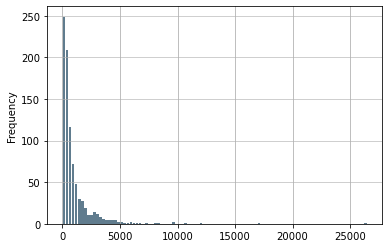

In [13]:
# 看讚數的分佈 y 軸是該讚數的貼文數 來看我們要怎麼取哪個讚數區間資料
commutes = lo_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [14]:
temp = lo_post[(lo_post['like_count'] <= 500) & (lo_post['like_count'] > 100)] #讚數大於500 小於1000才取 : 201  篇文章
temp

,new_date,message,jieba_results,like_count
58,2019-07-04,「學音樂的孩子不會變壞」，因為他們比一般的學生有著更多的專注與自律！昨晚出席 海山高中國中部管樂團的成果發表會，讓我更深信這句話。\r\n\r\n雖然不是音樂班學生，而是同學們在每天放學後及周六勤練所組成的社團，但展現的卻是超水準的音樂饗宴，難怪參加校外比賽獲獎無數，到各地交流巡迴表演，更曾在板橋火車站及台中高鐵站快閃演出。\r\n\r\n做為一個音樂愛好者及玩樂器的人，我知道樂器的好壞會影響到學習的興趣與信心。\r\n\r\n所以當家長會林俊星會長向我表示海山管樂團的樂器老舊，管樂室也有待改善時，我立刻答應協助爭取經費，也很高興去年底獲得教育部一百萬元的補助。\r\n\r\n希望新的樂器以及更好的練團環境，可以讓這群愛音樂的小朋友更能大展身手，為我們演出更優美動人的音樂！\r\n\r\n#感謝海山高中管樂團後援會\r\n#懷念大學玩樂團的日子\r\n#我的Bass是Fender,學音樂 的 孩子 不會 變壞 因為 他們 比 一般 的 學生 有 著 更 多 的 專注 與 自律 昨晚 出席 海山 高 中國 中部 管樂團 的 成果 發表會 讓 我 更 深信 這句 話 。 \r\r雖然 不是 音樂班學生 而是 同學們 在 每天 放學後及 周六 勤練 所 組成 的 社團 但展現 的 卻 是 超水準 的 音樂 饗 宴 難怪 參加 校外 比賽 獲獎 無數 到 各地 交流 巡 迴 表演 更 曾 在 板橋 火 車站 及台 中 高鐵站 快 閃 演出 。 \r\r做 為 一個 音樂 愛好者 及 玩樂器 的 人 我 知道 樂器 的 好 壞會 影響 到 學習 的 興趣 與 信心 。 \r\r所以 當家長 會 林俊星 會長 向 我 表示 海山 管樂團 的 樂器 老舊 管樂室 也 有待 改善 時 我 立刻 答應 協助 爭取 經費 也 很 高興 去年底 獲得 教育部 一百 萬元 的 補助 。 \r\r希望 新 的 樂器 以及 更好 的 練團 環境 可以 讓 這群 愛音樂 的 小朋友 更能 大展身手 為 我們 演出 更 優美動 人 的 音樂 \r\r# 感謝 海山 高中 管樂 團後援會 \r# 懷念大學 玩樂團 的 日子 \r# 我 的 是,101
59,2019-04-13,接地氣，有活力😊\r\n\r\n今天參加 妙雲宮。王禪老祖開基祖廟的遶境活動，走了三個半小時，但一點都不累，看到小朋友在路邊拿香拜拜，覺得好感動！\r\n\r\n我把人生比喻成進香，總會遇到腳痛、體力極限種種困難，只要心態正向積極，充滿活力，咬緊牙關撐過去， 一定會到達目的地。\r\n\r\n遇到困難就解決，不到終點不放棄，這是我和神明的約定，也是和自己的約定。💪\r\n\r\n📖小知識：香火鼎盛的板橋妙雲宮，占地350多坪，是板橋地區重要的信仰中心。廟裡供奉的王禪老祖，是春秋戰國時代著名的通才鬼谷子，孫臏、龐涓都是他的弟子。\r\n\r\n#與神同行\r\n#與民同行\r\n#板橋妙雲宮王禪老祖五路財神聯合遶境,接地氣 有 活力 😊 \r\r今天 參加 妙雲宮 。 王禪 老祖 開基祖廟 的 遶 境 活 動 走 了 三個 半小時 但 一點 都 不累 看到 小朋友 在 路邊 拿 香 拜拜 覺得 好感 動 \r\r我 把 人生 比喻 成進 香 總會 遇到 腳痛 體力 極限種種 困難 只要 心態 正向 積極 充滿 活力 咬 緊牙關 撐過 去 一定 會到 達 目的地 。 \r\r遇到 困難 就 解決 不到 終點 不放棄 這是 我 和 神明 的 約定 也 是 和 自己 的 約定 。 💪 \r\r📖 小知識 香火 鼎盛 的 板橋 妙雲宮 占地 多坪 是 板橋 地區 重要 的 信仰 中心 。 廟裡 供奉 的 王禪 老祖 是 春秋 戰國 時代 著名 的 通才 鬼谷子 孫臏 龐 涓 都 是 他 的 弟子 。 \r\r# 與 神 同行 \r# 與民 同行 \r# 板橋 妙雲宮 王禪 老祖 五路 財神 聯合 遶 境,104
60,2019-07-02,您知道學習環境的舒適度與學習成效有相關聯嗎？\r\n\r\n現在的天氣越來越熱，當然會造成孩子們的煩躁心情，\r\n影響他們的專心學習。\r\n\r\n台北市去年宣布中小學教室全面裝設冷氣，\r\n我們新北市的教室卻普遍沒有冷氣，\r\n其中的原因，並不完全是因為買不起冷氣，\r\n而是因為教室電源設備老舊，\r\n需要更大筆的經費來更換。\r\n\r\n去年底我為板橋中山國中爭取到\r\n#教育部400萬元的電源設備改善經費，\r\n學校利用假日期間拼命趕工，\r\n終於在近日完工驗收，\r\n讓八年級30個班的近千位同學，\r\n立刻可以不用再汗流浹背讀書，\r\n而七年級的另外30個班，也將陸續擁有冷氣教室。\r\n\r\n今天來到學校，校長告訴我冷氣完裝得正是時候，因為兩個禮拜之後，暑期輔導班就要開始了，\r\n希望舒適的教室可以讓同學們更專心學習，\r\n考出更好的成績，而這也是我的期待！\r\n\r\n謝謝校長陳君武、家長會長郭妃妃、黃國訓。\r\n\r\n#讓板橋中小學生有冷氣吹\r\n#板橋無限政在實現,您 知道 學習 環境 的 舒 適度 與 學習 成效 有 相關聯 嗎 \r\r現在 的 天氣 越來 越熱 當然會 造成 孩子 們 的 煩躁 心情 \r影響 他們 的 專心 學習 。 \r\r台北市 去年 宣布 中小 學 教室 全面 裝設 冷氣 \r我們 新北市 的 教室 卻 普遍 沒有 冷氣 \r其中 的 原因 並不 完全 是 因為 買 不起 冷氣 \r而是 因為 教室 電源 設備 老舊 \r需要 更大筆 的 經費來 更換 。 \r\r去年底 我為 板橋 中山 國中 爭取 到 \r# 教育部 萬元 的 電源 設備 改善 經費 \r學校 利用 假 日期 間 拼命 趕工 \r終於在 近日 完工 驗收 \r讓 八年 級 個班 的 近 千位 同學 \r立刻 可以 不用 再 汗流 浹 背 讀書 \r而 七年 級 的 另外 個班 也 將陸續 擁有 冷氣 教室 。 \r\r今天 來 到 學校 校長 告訴 我 冷氣 完裝 得 正是 時候 因為 兩個 禮拜 之 後 暑期 輔導班 就要 開始 了 \r希望 舒適 的 教室 可以 讓 同學們 更 專心 學習 \r考 出 更好 的 成績 而 這也 是 我 的 期待 \r\r謝謝 校長 陳 君武 家長 會長 郭妃 妃 黃 國訓 。 \r\r# 讓 板橋 中小 學生 有 冷氣 吹 \r# 板橋 無限政 在 實現,106
61,2019-04-16,午安！來看 蔡英文 Tsai Ing-wen總統的魔術初體驗🎊\r\n\r\n用有趣的方式談嚴肅的議題，才能讓全民共同參與。\r\n\r\n我想跟魔術師 吳何 Horret Wu 說：\r\n\r\n在台灣你可以當面送總統空心菜，\r\n但在中國，你連送習近平包子、在網路說他是小熊維尼的權利都沒有。\r\n\r\n能決定我們未來的人，\r\n不是別人，\r\n就是我們自己。\r\n\r\n🎊魔術影片:https://tinyurl.com/y2decp5a,午安 來 看 蔡英文 - 總統 的 魔術 初體驗 🎊 \r\r用 有趣 的 方式 談 嚴肅 的 議題 才能 讓 全民 共同 參與 。 \r\r我 想 跟 魔術師 吳何 說 \r\r在 台灣 你 可以 當面 送 總統 空心菜 \r但 在 中國 你 連送 習近平 包子 在 網路 說 他 是 小熊 維尼 的 權利 都 沒 有 。 \r\r能 決定 我們 未來 的 人 \r不是 別人 \r就是 我們 自己 。 \r\r🎊 魔術 影片 / / . /,106
62,2019-04-11,報稅5月天，還不清楚新的稅制可以讓你減輕多少負擔嗎？\r\n\r\n跟著路線走，把路過金額加總➡你適用的扣除額度\r\n如果年所得低於合計的扣除額度➡免繳稅。\r\n\r\n（圖片來源： 中華民國財政部 ）\r\n\r\n👉綜所稅線上試算工具：http://bit.ly/2U5UGvf\r\n\r\n#化繁為簡報稅不難,報稅 月 天 還不 清楚 新 的 稅制 可以 讓 你 減輕 多少 負擔 嗎 \r\r跟 著路線 走 把 路過 金額加 總 ➡ 你 適用 的 扣除 額度 \r如果 年 所得 低 於 合計 的 扣除 額度 ➡ 免 繳稅 。 \r\r圖片 來源 中華民國 財政部 \r\r👉 綜所稅 線上 試算 工具 / / . / \r\r# 化繁為簡 報稅 不難,108
...,...,...,...,...
434,2019-07-20,#自由民主永續之旅\r\n#感受僑胞熱情\r\n#丹佛\r\n\r\n剛抵達此次外交之旅的最後一站，美國丹佛。\r\n\r\n不意外，少數中國僑民被動員到蔡英文 Tsai Ing-wen總統下塌丹佛的飯店外抗議。\r\n\r\n意外的是，怎麼連舉牌的標語、輸出字型、喊的口號，都跟紐約那群使用的一樣，實在太沒創意了。\r\n\r\n相較之下，我們一下車就感受到台僑的熱情，而今晚的餐宴，更由原本規劃的四十桌，爆桌到七十桌，從全美各地都有僑胞飛來，甚至還有開兩三天車的，太感謝大家了！,# 自由民主 永續之旅 \r# 感受 僑胞 熱情 \r# 丹佛 \r\r剛抵 達 此次 外交 之旅 的 最 後 一站 美國 丹佛 。 \r\r不 意外 少數 中國 僑民 被 動員到 蔡英文 - 總統 下 塌 丹佛 的 飯店 外抗 議 。 \r\r意外 的 是 

TF-IDF 我們把剛才斷好詞的貼文，轉成list形式，全部放到corpus變數裡面，方便做tf-idf處理。
CountVectorizer算字頻（搭配fit_transform） TfidfTransformer計算TFIDF

In [16]:
corpus = temp['jieba_results'].values.tolist() #如果不做這個、結果會不同 太generall

In [17]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [18]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,___,_____,______,一一,一下,一事,一人限購,一代,一件,一位,...,黨政軍及,黨產,黨部,鼎力,鼎盛,鼓勵,鼻孔,齊心,齊聚,龍安里
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.099549,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.000000,0.0,0.0,0.0,0.088657,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
377,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
378,0.101975,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
379,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=8, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['安全', '美國', '通過', '今天', '足球', '中國', '大家', '板橋', '致政', '台灣']
TOP 10 WORDS PER TOPIC #1
['實現', '今天', '中國', '政府', '大家', '申請', '我們', '台灣', '香港', '板橋']
TOP 10 WORDS PER TOPIC #2
['實現', '直播', '爭取', '大家', '一起', '致政', '外交', '我們', '台灣', '板橋']
TOP 10 WORDS PER TOPIC #3
['可以', '台灣', '朋友', '實現', '無限政', '致政', '今天', '我們', '大家', '板橋']
TOP 10 WORDS PER TOPIC #4
['自己', '美國', '大家', '條例', '板橋', '酒駕', '我們', '香港', '中國', '台灣']
TOP 10 WORDS PER TOPIC #5
['今天', '記者', '一國兩制', '政府', '中共', '我們', '媒體', '中國', '香港', '台灣']
TOP 10 WORDS PER TOPIC #6
['扣除', '蔡英文', '我們', '致政', '美國', '可以', '國家', '今天', '總統', '台灣']
TOP 10 WORDS PER TOPIC #7
['補助', '今天', '爭取', '大家', '我們', '地下', '致政', '公園', '停車場', '板橋']


In [20]:
LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['香港', '活動', '一起', '美國', '今天', '我們', '大家', '致政', '台灣', '板橋']
TOP 10 WORDS PER TOPIC #1
['民進黨', '今天', '致政', '我們', '總統', '酒駕', '香港', '大家', '台灣', '板橋']
TOP 10 WORDS PER TOPIC #2
['記者', '蔡英文', '接到', '我們', '服務', '總統', '政治', '香港', '中國', '台灣']
TOP 10 WORDS PER TOPIC #3
['大家', '目的', '天下', '考生', '香港', '足球', '政府', '媒體', '板橋', '台灣']
TOP 10 WORDS PER TOPIC #4
['停車', '施工', '五權', '台灣', '致政', '爭取', '板橋', '公園', '地下', '停車場']
TOP 10 WORDS PER TOPIC #5
['歡迎', '苗栗', '加油', '媒體', '我會', '中國', '板橋', '我們', '台灣', '香港']
TOP 10 WORDS PER TOPIC #6
['一起', '電話', '香港', '我們', '致政', '總統', '板橋', '大家', '台灣', '直播']
TOP 10 WORDS PER TOPIC #7
['掃街', '共餐', '大家', '國家', '一起', '我們', '今晚', '中國', '板橋', '台灣']


In [21]:
#政見做斷詞

politics_lo = politics[politics.姓名 == "羅 致 政"].政見.to_string()
politics_lo = re.sub(re_punctuation, "", politics_lo)
politics_lo = re.sub(r'[0-9]','',politics_lo)
politics_lo = re.sub(r'[a-zA-Z]','',politics_lo)
politics_lo = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',politics_lo)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
words = jieba.lcut(politics_lo, cut_all = False)
words

[' ',
 ' ',
 ' ',
 ' ',
 '「',
 '改變',
 '」',
 '是',
 '這些',
 '年',
 '最響',
 '亮',
 '的',
 '政治',
 '廣告',
 '口號',
 '，',
 '但要',
 '改變',
 '什麼',
 '呢',
 '？',
 '四年',
 '前當',
 '我決',
 ' ',
 '定',
 '繼續',
 '在',
 '板橋',
 '基層',
 '深耕',
 '後',
 '，',
 '就',
 '深刻',
 '體認',
 '：',
 '我',
 '不再',
 '是',
 '一個',
 '可以',
 '隱遁',
 '在',
 '寧靜校',
 '園裡',
 '的',
 ' ',
 '大學',
 '老師',
 '，',
 '我',
 '必須',
 '和',
 '大家',
 '一起',
 '呼吸',
 '，',
 '勇敢',
 '面對',
 '人世',
 '間',
 '的',
 '不義和苦',
 '難',
 '這些',
 '年',
 '來',
 '我',
 '選擇',
 '以無給',
 '職',
 '的',
 '新北市',
 '黨部',
 '主委',
 '做',
 '為',
 '舞台',
 '，',
 '全力',
 '為民眾',
 '和',
 '公職',
 '人員',
 '搭',
 '好',
 '溝通',
 '的',
 ' ',
 '橋',
 '樑',
 '我',
 '深切',
 '體認',
 '，',
 '大家',
 '想',
 '改變',
 '的',
 '不是',
 '只換個',
 '政黨',
 '執政',
 '而已',
 '，',
 '而是',
 '有',
 '權力',
 '的',
 '人',
 '可',
 ' ',
 '以',
 '用心',
 '讓',
 '小市民',
 '生活',
 '過得',
 '更好',
 ' ',
 '這是',
 '我',
 '的',
 '從政',
 '初衷',
 '沒有',
 '派系',
 '，',
 '也',
 '不是',
 '政治',
 '世家',
 '，',
 '選擇',
 '從',
 '校園',
 '踏進',
 '政治',
 '圈',
 '答案',
 '始終',
 '只有',
 '一個',
 '，',
 '就是',
 '為',
 '了',
 '實踐',
 '理想',
 '羅致政

In [22]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_lo, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',text)
text = re.sub(re_punctuation, "", text)
text

'         改變 是 這些 年 最響 亮 的 政治 廣告 口號 但要 改變 什麼 呢 四年 前當 我決   定 繼續 在 板橋 基層 深耕 後 就 深刻 體認 我 不再 是 一個 可以 隱遁 在 寧靜校 園裡 的   大學 老師 我 必須 和 大家 一起 呼吸 勇敢 面對 人世 間 的 不義和苦 難 這些 年 來 我 選擇 以無給 職 的 新北市 黨部 主委 做 為 舞台 全力 為民眾 和 公職 人員 搭 好 溝通 的   橋 樑 我 深切 體認 大家 想 改變 的 不是 只換個 政黨 執政 而已 而是 有 權力 的 人 可   以 用心 讓 小市民 生活 過得 更好   這是 我 的 從政 初衷 沒有 派系 也 不是 政治 世家 選擇 從 校園 踏進 政治 圈 答案 始終 只有 一個 就是 為 了 實踐 理想 羅致政 承諾將 以 正直 理性 問政 人民   福祉 優先 的 理念 來 落實 國會 改革 與 為民 服務 的 目標 一 國會 改革   １   以 國家 和 人民 的 利益 為 先 政黨 和 個 人 的 利益 為 後   ２   國會 運作 公開 透明 讓 立法院 不再 有 密室 政治 黑箱 運作 的 空間 提高 立法   院 問政 效率   ３   修法 降低 公投法 和 修憲門檻 實現 歲 投票 權訴 求 保障 直接 民權 補足代   議 制度 的 缺陷   二 為民 服務   １   推動 十年 長照 計畫 落實 長照 托育 女性 就業 三合一 照顧 政策 減輕婦 女照 顧 重擔   ２   推動 食安五環 計畫 從 食品 源頭 就 全面 監控 對 黑心 廠商 課以 更重 的 法   律責任   ３   配合 五大 創新 研發 計畫 調整 高等教育 階段 的 課程 與 科系 解決 大學 畢   業生 學用 落差 問題   ４   提供 只租 不售 的 高品質 青年 社會住宅 並針 對 特殊 居住 要求 以及 弱勢 者 提供   補助   ５   確保國 內 文化 多樣 性 積極 保存 維護 和 活化 有形 及 非物質 的 文化 資產'

In [29]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(words)
word = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=8, random_state=None)

#政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)

TOP 10 WORDS PER TOPIC #0
['空間', '補助', '不義和苦', '這是', '源頭', '勇敢', '照顧', '重擔', '不是', '計畫']
TOP 10 WORDS PER TOPIC #1
['可以', '沒有', '寧靜校', '面對', '課程', '以及', '公開', '提供', '體認', '落實']
TOP 10 WORDS PER TOPIC #2
['什麼', '過得', '十年', '配合', '大學', '為民', '長照', '大家', '改變', '政治']
TOP 10 WORDS PER TOPIC #3
['確保國', '密室', '只有', '公職', '課以', '而是', '社會住宅', '推動', '運作', '服務']
TOP 10 WORDS PER TOPIC #4
['有形', '舞台', '不售', '理念', '正直', '律責任', '直接', '一個', '文化', '國會']
TOP 10 WORDS PER TOPIC #5
['五大', '實踐', '修憲門檻', '執政', '學用', '補足代', '投票', '減輕婦', '這些', '問政']
TOP 10 WORDS PER TOPIC #6
['食品', '修法', '隱遁', '並針', '板橋', '必須', '黑心', '政黨', '利益', '人民']
TOP 10 WORDS PER TOPIC #7
['業生', '調整', '人世', '初衷', '女性', '而已', '多樣', '選擇', '不再', '改革']


In [30]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

空間, 補助, 不義和苦, 這是, 源頭, 勇敢, 照顧, 重擔, 不是, 計畫, 可以, 沒有, 寧靜校, 面對, 課程, 以及, 公開, 提供, 體認, 落實, 什麼, 過得, 十年, 配合, 大學, 為民, 長照, 大家, 改變, 政治, 確保國, 密室, 只有, 公職, 課以, 而是, 社會住宅, 推動, 運作, 服務, 有形, 舞台, 不售, 理念, 正直, 律責任, 直接, 一個, 文化, 國會, 五大, 實踐, 修憲門檻, 執政, 學用, 補足代, 投票, 減輕婦, 這些, 問政, 食品, 修法, 隱遁, 並針, 板橋, 必須, 黑心, 政黨, 利益, 人民, 業生, 調整, 人世, 初衷, 女性, 而已, 多樣, 選擇, 不再, 改革, 

In [31]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#產業升級、園區、高科技園區、加工區 、楠梓、交通、三鐵同構

Counter({'空間': 1,
         '補助': 2,
         '不義和苦': 1,
         '這是': 1,
         '源頭': 1,
         '勇敢': 1,
         '照顧': 1,
         '重擔': 1,
         '不是': 1,
         '計畫': 1,
         '可以': 3,
         '沒有': 1,
         '寧靜校': 1,
         '面對': 1,
         '課程': 1,
         '以及': 1,
         '公開': 1,
         '提供': 1,
         '體認': 1,
         '落實': 1,
         '什麼': 1,
         '過得': 1,
         '十年': 1,
         '配合': 1,
         '大學': 1,
         '為民': 1,
         '長照': 1,
         '大家': 7,
         '改變': 1,
         '政治': 1,
         '確保國': 1,
         '密室': 1,
         '只有': 1,
         '公職': 1,
         '課以': 1,
         '而是': 1,
         '社會住宅': 1,
         '推動': 1,
         '運作': 1,
         '服務': 1,
         '有形': 1,
         '舞台': 1,
         '不售': 1,
         '理念': 1,
         '正直': 1,
         '律責任': 1,
         '直接': 1,
         '一個': 1,
         '文化': 1,
         '國會': 1,
         '五大': 1,
         '實踐': 1,
         '修憲門檻': 1,
         '執政': 1,
         '學用': 1,
 

In [32]:
top_10_message = tfidf_view.sort_values(by = ['社會住宅'], ascending = False).index[:10] # 把高科技tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['社會住宅'], ascending = False).head(10)

,___,_____,______,一一,一下,一事,一人限購,一代,一件,一位,...,黨政軍及,黨產,黨部,鼎力,鼎盛,鼓勵,鼻孔,齊心,齊聚,龍安里
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[52,]).sort_values(by = 52, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption

,52
明會,0.459214
五權,0.449024
施工,0.416482
停車場,0.377269
地下,0.372770
...,...
將情,0.000000
將帥,0.000000
將導致,0.000000
將官,0.000000


In [34]:
#這些都是讚數很高的文章 每篇文章最高的tfidf 詞
message_newtfidf = tfidf_view
message_newtfidf['term'] = message_newtfidf[message_column].idxmax(axis = 1)
message_newtfidf['term'].tail(20) # 在這邊的話看讚數最多的文章他們tfidf 最高的詞是什麼

361     選票
362    停車場
363     知道
364    停車場
365     上展
366     慎終
367    公督盟
368    民進黨
369     成長
370     皇家
371     公教
372    之後拼
373     直播
374     香港
375     掃街
376     丹佛
377     匝道
378     寵物
379     二台
380     祝福
Name: term, dtype: object

In [35]:
#politics_word
match_column = list(set(words).intersection(vectorizer.get_feature_names()))
match_column

['黑心',
 '實踐',
 '特殊',
 '公開',
 '保障',
 '業生',
 '大學',
 '落實',
 '承諾將',
 '多樣',
 '透明',
 '基層',
 '執政',
 '修法',
 '目標',
 '人員',
 '世家',
 '可以',
 '有形',
 '直接',
 '生活',
 '派系',
 '答案',
 '計畫',
 '公投法',
 '優先',
 '前當',
 '體認',
 '確保國',
 '問題',
 '寧靜校',
 '利益',
 '只換個',
 '過得',
 '正直',
 '立法',
 '大家',
 '補足代',
 '資產',
 '密室',
 '補助',
 '課程',
 '為民眾',
 '要求',
 '廠商',
 '階段',
 '改變',
 '踏進',
 '政治',
 '這些',
 '理性',
 '提供',
 '以無給',
 '必須',
 '配合',
 '羅致政',
 '弱勢',
 '減輕婦',
 '用心',
 '高等教育',
 '而是',
 '不再',
 '長照',
 '課以',
 '繼續',
 '居住',
 '改革',
 '提高',
 '選擇',
 '溝通',
 '不義和苦',
 '非物質',
 '落差',
 '投票',
 '不售',
 '一個',
 '權訴',
 '科系',
 '照顧',
 '我決',
 '校園',
 '托育',
 '食安五環',
 '並針',
 '福祉',
 '舞台',
 '積極',
 '立法院',
 '調整',
 '不是',
 '問政',
 '深切',
 '只有',
 '理念',
 '空間',
 '食品',
 '就業',
 '從政',
 '老師',
 '只租',
 '國家',
 '國會',
 '運作',
 '理想',
 '黑箱',
 '更好',
 '小市民',
 '深耕',
 '園裡',
 '四年',
 '什麼',
 '創新',
 '推動',
 '隱遁',
 '五大',
 '但要',
 '面對',
 '源頭',
 '就是',
 '全面',
 '權力',
 '而已',
 '人民',
 '公職',
 '律責任',
 '保存',
 '新北市',
 '政黨',
 '初衷',
 '修憲門檻',
 '解決',
 '廣告',
 '服務',
 '社會住宅',
 '女性',
 '效率',
 '女照',
 '更重',
 '實現',
 '

In [36]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,一個,一起,三合一,不再,不售,不是,不義和苦,世家,並針,主委,...,非物質,面對,食品,食安五環,體認,高品質,高等教育,黑心,黑箱,黨部
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[371,]

new_date                                                                                                                                                                                                                                                                                                         2019-08-23
message                                                          軍公教年改 大法官會議宣告絕大部分合憲\r\n\r\n軍公教年金改革釋憲案，簡單來說，就是  #大部分合憲、#不違背信賴保護原則、#不違背憲法保障財產權。\r\n\r\n違憲部分僅在於退休軍公教再任私立學校的限制規定。\r\n\r\n這次釋憲案的15位大法官，過半數是馬政府時期提名的，所以年金改革釋憲案的結果應該具有公信力。\r\n\r\n#領得到領到老\r\n#有保障沒煩惱\r\n\r\n👉 軍公教年改釋憲案  大法官宣告「大部分合憲」：https://tinyurl.com/yxebeoqc
jieba_results     軍 公教 年 改   大法官 會議 宣告 絕 大部分 合憲 \r\r軍 公教 年 金 改革 釋憲案 簡單 來 說 就是     # 大部分 合憲 # 不違 背信 賴保護 原則 # 不違 背憲法 保障 財產權 。 \r\r違憲 部分 僅在 於 退休 軍 公教 再任 私立 學校 的 限制 規定 。 \r\r這次釋 憲案 的  位 大法官 過半數 是 馬 政府 時期 提名 的 所以 年 金 改革 釋憲案 的 結果 應該 具有 公信力 。 \r\r# 領 得到 領到 老 \r# 有 保障 沒煩惱 \r\r👉   軍 公教 年 改釋 憲案     大法官 宣告 大部分 合憲  / /  .  / 
like_count                                          

In [40]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,黑心,實踐,特殊,公開,保障,業生,大學,落實,承諾將,多樣,...,監控,始終,黨部,沒有,深刻,十年,文化,學用,民權,人世
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [41]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)
match_document_politics

<ipython-input-41-1ded51f200cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


,黑心,實踐,特殊,公開,保障,業生,大學,落實,承諾將,多樣,...,始終,黨部,沒有,深刻,十年,文化,學用,民權,人世,sum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [42]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #平均一個詞 375篇中會有1篇有包含政策相關的

1.1754385964912282

In [43]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) # 相關度0.3%

0.003085140673205323